# Multi-Modal Spectral Clustering GMM Comparison

In [19]:
# General-purpose imports
import numpy as np
import random
from itertools import product

# Machine learning and clustering
from sklearn.cluster import SpectralClustering, KMeans, spectral_clustering
from sklearn.metrics.pairwise import rbf_kernel, euclidean_distances
from sklearn.metrics import (
    confusion_matrix,
    adjusted_rand_score,
    normalized_mutual_info_score,
)
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA

# Graph neural networks
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, DataLoader
from torch.utils.data import DataLoader
from torch.autograd import Variable

# Tensor decomposition
import tensorly as tl
from tensorly.decomposition import parafac

# Data visualization
import matplotlib.pyplot as plt

# Dataset handling
from sklearn.datasets import fetch_openml

# Torchvision (for dataset transformations)
from torchvision import datasets, transforms

# Optimization
from scipy.optimize import linear_sum_assignment

# Similarity network fusion
from snf.compute import make_affinity, snf

import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import CCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import time

import numpy as np
from scipy.spatial.distance import cdist
from scipy import sparse, stats
from sklearn.utils.validation import (check_array, check_symmetric,
                                      check_consistent_length)

import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.linalg import svd
import numpy as np
import time
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

MAX_NUM_CLUSTERS = 15

import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.linalg import svd
from sklearn.cluster import KMeans
import numpy as np
import time

from matplotlib import cm
from matplotlib.colors import Normalize

## ARW and Simple Fusion Methods Implementation

In [24]:
def MultiModal_SpectralClustering_ARW(X_list, n_clusters):
    random_walk_matrix_multimodal = np.identity(X_list[0].shape[0])
    K = 20  # Number of nearest neighbors to preserve

    for X in X_list:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Compute the similarity matrix
        similarity_matrix = make_affinity(X_scaled, metric='euclidean', K=K, mu=0.5)

        # Keep only the K-nearest neighbors explicitly
        similarity_matrix = retain_k_nearest(similarity_matrix, K=K)

        # Compute the degree matrix and random walk matrix
        degree_matrix = np.diag(np.sum(similarity_matrix, axis=1))
        random_walk_matrix = np.linalg.inv(degree_matrix) @ similarity_matrix

        random_walk_matrix_multimodal = random_walk_matrix_multimodal @ random_walk_matrix

    # Symmetrize the random walk matrix
    random_walk_matrix_multimodal_sym = (random_walk_matrix_multimodal + random_walk_matrix_multimodal.T) / 2

    # Perform spectral clustering
    clusters_multimodal = spectral_clustering(
        affinity=random_walk_matrix_multimodal_sym,
        n_clusters=n_clusters,
        assign_labels="kmeans",
        n_init=10,
        eigen_tol=1e-4,
        random_state=42
    )

    return clusters_multimodal


def retain_k_nearest(W, K=20):
    """
    Retain only the K-nearest neighbors in the similarity matrix.

    Args:
        W: The similarity matrix (affinity matrix).
        K: The number of nearest neighbors to retain.

    Returns:
        A sparse-like normalized matrix where only the top-K connections are retained.
    """
    # Sort the similarity matrix row-wise and retain only the top-K values
    W_sorted = np.sort(W, axis=1)[:, ::-1]  # Sort in descending order
    kth_value = W_sorted[:, K - 1:K]  # Get the K-th largest value for each row

    # Zero out all values below the K-th largest value in each row
    W_retained = np.where(W >= kth_value, W, 0)

    # Normalize each row to sum to 1 (to make it a proper random walk matrix)
    W_normalized = W_retained / np.sum(W_retained, axis=1, keepdims=True)

    return W_normalized

def log_and_normalize(omics_list, normalize=True, filter_var=True):
    
    # Log-transform for sequence data (adjust for non-positive values)
    omics_list = [np.log1p(omics - np.min(omics) + 1) if np.any(omics < 0) else np.log1p(omics) for omics in omics_list]

    if filter_var:
        omics_list = [keep_high_variance_features(omics) for omics in omics_list]

    if normalize:
        scaler = StandardScaler()
        omics_list = [scaler.fit_transform(omics) for omics in omics_list]

    return omics_list

def keep_high_variance_features(omics, num_features=2000):
    
    if omics.shape[1] <= num_features:
        return omics
    feature_variances = np.var(omics, axis=1)
    threshold = np.sort(feature_variances)[-num_features]
    return omics[feature_variances >= threshold, :]

# Single-modal spectral clustering
def SpectralClustering_Single(X, n_clusters, Use_PCA):

    # 1. Feature normalization
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 2. Optional PCA
    if Use_PCA:
        pca = PCA(n_components=min(50, X_scaled.shape[1]))
        X_pca = pca.fit_transform(X_scaled)
    else:
        X_pca = X_scaled

    # 3. Compute similarity matrix
    gamma_pick = 1 / (2 * np.var(X_pca))
    similarity_matrix = rbf_kernel(X_pca, gamma=gamma_pick)

    # 4. Spectral clustering
    clusters = spectral_clustering(
        affinity=similarity_matrix,
        n_clusters=n_clusters,
        assign_labels="kmeans",
        n_init=10,
        eigen_tol=1e-4,
        random_state=42
    )
    return clusters

# Multi-modal spectral clustering via alternating random walk
def MultiModal_SpectralClustering_Ave(X_list, n_clusters):

    matrix_multimodal = np.zeros([X_list[0].shape[0],X_list[0].shape[0]])

    for X in X_list:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        gamma = 1 / (2 * np.var(X_scaled))
        similarity_matrix = rbf_kernel(X_scaled, gamma=gamma)
        matrix_multimodal = matrix_multimodal + similarity_matrix

    clusters_multimodal = spectral_clustering(
        affinity=matrix_multimodal,
        n_clusters=n_clusters,
        assign_labels="kmeans",
        n_init=10,
        eigen_tol=1e-4,
        random_state=42
    )
    return clusters_multimodal


def MultiModal_SpectralClustering_Concat(X_list, n_clusters):

    # 1. Normalize and balance each modality
    normalized_modalities = []
    weights = [1.0 for _ in X_list]  # Assign weights (adjust based on importance)
    for i, X in enumerate(X_list):
        X_scaled = StandardScaler().fit_transform(X)
        modality_scale = np.linalg.norm(X_scaled, 'fro')  # Normalize using Frobenius norm
        X_scaled /= modality_scale
        normalized_modalities.append(weights[i] * X_scaled)

    # 2. Concatenate modalities
    X_weighted_concatenation = np.hstack(normalized_modalities)

    # 3. Compute similarity matrix
    gamma_concatenation = 1 / (2 * np.var(X_weighted_concatenation))
    similarity_matrix_concatenation = rbf_kernel(X_weighted_concatenation, gamma=gamma_concatenation)

    # 4. Perform spectral clustering
    clusters_concatenation = spectral_clustering(
        affinity=similarity_matrix_concatenation,
        n_clusters=n_clusters,
        assign_labels="kmeans",
        n_init=10,
        eigen_tol=1e-4,
        random_state=42
    )
    return clusters_concatenation

def MultiModal_SpectralClustering_Tensor(X_list, n_clusters):

    # 1. Stack data to form a 3D tensor
    tensor = np.stack(X_list, axis=2)  # Create tensor of shape (samples, features, modalities)

    # 2. Compute pairwise distances between tensor slices along dimension 0
    num_samples = tensor.shape[0]
    combined_distances = np.zeros((num_samples, num_samples))  # Initialize distance matrix

    for i in range(num_samples):
        for j in range(num_samples):
            # Compute distance between slices tensor[i, :, :] and tensor[j, :, :]
            slice_i = tensor[i, :, :].flatten()  # Flatten into 1D vector
            slice_j = tensor[j, :, :].flatten()  # Flatten into 1D vector
            combined_distances[i, j] = np.linalg.norm(slice_i - slice_j)  # Euclidean distance

    # 3. Convert distances to similarities
    gamma_tensor = 1 / (2 * np.var(combined_distances))
    similarity_matrix_tensor = np.exp(-gamma_tensor * combined_distances)

    # 4. Perform spectral clustering
    clusters_tensor = spectral_clustering(
        affinity=similarity_matrix_tensor,
        n_clusters=n_clusters,
        assign_labels="kmeans",
        n_init=10,
        eigen_tol=1e-4,
        random_state=42
    )
    return clusters_tensor

# Gaussian Mixture Model Sampler
def GMM_sampler(X, y, dim, var_scale, fixed_mean=False, mean_list=None, fixed_cov=False, cov_list=None):

    # Number of classes
    n_classes = len(np.unique(y))

    # Initialize the output dataset
    X_G = np.zeros((X.shape[0], dim))

    # Validate mean_list if fixed_mean is True
    if fixed_mean and (mean_list is None or len(mean_list) != n_classes):
        raise ValueError("If fixed_mean is True, mean_list must be provided with one mean per class.")
    # Validate mean_list if fixed_mean is True
    if fixed_cov and (cov_list is None or len(cov_list) != n_classes):
        raise ValueError("If fixed_cov is True, cov_list must be provided with one cov per class.")

    # Generate Gaussian samples for each class
    for label in np.unique(y):
        # Number of samples for the current class
        n_samples = np.sum(y == label)

        # Use the fixed mean or generate a random one
        if fixed_mean:
            mean = mean_list[label]
        else:
            mean = np.random.uniform(-5, 5, size=dim)

        if fixed_cov:
            cov = cov_list[label] * var_scale
        else:
            # Generate a random covariance matrix
            cov = np.random.rand(dim, dim)
            cov = np.dot(cov, cov.T) * var_scale  # Make it symmetric and positive-definite

        # Sample points from the Gaussian distribution
        X_sampled = np.random.multivariate_normal(mean, cov, n_samples)

        # Assign the sampled points to the output dataset
        X_G[np.where(y == label)] = X_sampled

    return X_G

# Evaluate clustering performance by comparing with true labels
def cluster_accuracy(y_true, y_pred):

    # Create a confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Use the Hungarian algorithm to find the optimal matching of predicted labels to true labels
    row_ind, col_ind = linear_sum_assignment(-cm)

    # Compute the accuracy based on this optimal matching
    accuracy = np.sum(cm[row_ind, col_ind]) / np.sum(cm)
    return accuracy


## MCCA Implementation

In [3]:
def minimize_sum_of_correlations_fixed(omics_list, n_components=10, n_iterations=100, tolerance=1e-4):

    # Initialize weights using SVD
    K = len(omics_list)
    weights = [svd(x, full_matrices=False)[2][:n_components].T for x in omics_list]

    # Normalize data
    standardized_omics = [StandardScaler().fit_transform(x) for x in omics_list]

    prev_crit = None  # Previous criterion value

    for iteration in range(n_iterations):
        # Compute current criterion
        crit = sum([
            np.corrcoef((standardized_omics[i] @ weights[i]).T, (standardized_omics[j] @ weights[j]).T).sum()
            for i in range(K) for j in range(i + 1, K)
        ])

        # Check convergence
        if prev_crit is not None:
            if abs(prev_crit) > 0:  # Normal convergence check
                if abs(prev_crit - crit) / abs(prev_crit) < tolerance:
                    break
            else:  # Handle case where prev_crit == 0
                if abs(crit) < tolerance:
                    break

        prev_crit = crit

        # Update weights for each view
        for i in range(K):
            combined_projections = sum([
                standardized_omics[j] @ weights[j] for j in range(K) if j != i
            ])
            weights[i] = np.linalg.pinv(standardized_omics[i]) @ combined_projections
            # Enforce orthogonality constraint on weights
            weights[i] = weights[i] / np.linalg.norm(weights[i], axis=0, keepdims=True)

    # Compute projections
    projections = [x @ w for x, w in zip(standardized_omics, weights)]

    return {"weights": weights, "projections": projections}

def run_mcca_fixed_clusters(omics_list, n_clusters, n_components=10, max_iterations=100, tolerance=1e-4):

    if len(omics_list) == 1:
        return {"clustering": np.full(omics_list[0].shape[0], np.nan), "timing": 0}

    start_time = time.time()

    # Log and normalize the omics datasets
    omics_list = log_and_normalize(omics_list)

    # Perform MCCA with minimized sum of correlations
    mcca_result = minimize_sum_of_correlations_fixed(
        omics_list, 
        n_components=n_components, 
        n_iterations=max_iterations, 
        tolerance=tolerance
    )

    # Use the projections from the first view for clustering
    reduced_representation = mcca_result["projections"][0][:, :n_components]

    # Perform clustering with the fixed number of clusters
    clustering = KMeans(n_clusters=n_clusters, max_iter=100, n_init=30, random_state=42).fit_predict(
        reduced_representation
    )

    timing = time.time() - start_time

    return clustering

def run_mcca_simple(omics_list, max_clusters=15):

    if len(omics_list) == 1:
        return {"clustering": np.full(omics_list[0].shape[1], np.nan), "timing": 0}

    start_time = time.time()

    # Log and normalize the omics datasets
    omics_list = log_and_normalize(omics_list)

    # Perform Canonical Correlation Analysis
    cca = CCA(n_components=max_clusters)
    X_c, _ = cca.fit_transform(*omics_list[:2])  # Fit only the first two omics for simplicity

    # Reduce the shared representation to the optimal dimension
    explained_variances = [np.sum(np.var(X_c[:, :i + 1], axis=0)) for i in range(max_clusters)]
    optimal_dimension = find_elbow(explained_variances)
    reduced_representation = X_c[:, :optimal_dimension]

    # Perform clustering and silhouette analysis
    sils = []
    clusterings = []
    for num_clusters in range(2, max_clusters + 1):
        clustering = KMeans(n_clusters=num_clusters, max_iter=100, n_init=30).fit_predict(
            reduced_representation
        )
        sil = silhouette_score(reduced_representation, clustering)
        sils.append(sil)
        clusterings.append(clustering)

    # Choose the clustering with the maximum silhouette score
    best_clustering = clusterings[np.argmax(sils)]
    timing = time.time() - start_time

    return {"clustering": best_clustering, "timing": timing}

def run_mcca_fixed_clusters_simple(omics_list, n_clusters, max_components=10):

    if len(omics_list) == 1:
        return {"clustering": np.full(omics_list[0].shape[1], np.nan), "timing": 0}

    start_time = time.time()

    # Log and normalize the omics datasets
    omics_list = log_and_normalize(omics_list)

    # Perform Canonical Correlation Analysis
    cca = CCA(n_components=max_components)
    X_c, _ = cca.fit_transform(*omics_list[:2])  # Fit only the first two omics for simplicity

    # Reduce the shared representation to the optimal dimension
    reduced_representation = X_c[:, :max_components]  # Use all specified components

    # Perform clustering with the fixed number of clusters
    clustering = KMeans(n_clusters=n_clusters, max_iter=100, n_init=30).fit_predict(
        reduced_representation
    )
    timing = time.time() - start_time

    return clustering

## SNF Implementation

In [4]:
def MultiModal_SNF(omics_list, n_clusters, k=20, t=10):
    start_time = time.time()

    # Preprocess omics data
    #for i in range(len(omics_list)):
    #    scaler = StandardScaler()
    #    omics = omics_list[i]
    #    omics_list[i] = scaler.fit_transform(omics)

    omics_list = log_and_normalize(omics_list)

    # Compute affinity matrices for each omics dataset
    affinity_matrices = [make_affinity(omics, metric='euclidean', K=k, mu=0.5) for omics in omics_list]

    # Perform Similarity Network Fusion
    fused_matrix = snf(affinity_matrices, K=k, t=t)

    # Estimate the number of clusters
    num_clusters = n_clusters  # Replace with cluster estimation logic if needed

    # Perform spectral clustering
    spectral_model = SpectralClustering(n_clusters=num_clusters, affinity='precomputed', random_state=42)
    labels = spectral_model.fit_predict(fused_matrix)

    end_time = time.time()
    computation_time = end_time - start_time

    return labels

## Loading Data

In [5]:
# Load MNIST data (using fetch_openml for a clean dataset)
print("Loading MNIST data...")
mnist = fetch_openml('mnist_784', version=1)
data = mnist.data
labels = mnist.target.astype(int)

# Preprocessing: Reduce dimensionality using PCA for computational efficiency
print("Reducing dimensionality with PCA...")
pca = PCA(n_components=20)
data_reduced = pca.fit_transform(data)

# Normalize the data
print("Normalizing data...")
data_normalized = data_reduced / np.linalg.norm(data_reduced, axis=1, keepdims=True)

Loading MNIST data...
Reducing dimensionality with PCA...
Normalizing data...


## Toy expriment with three synthetic GMM modalities

### 1. Fixed mean and cov test

In [26]:
def run_GMM_variance_analysis_trimodal_fixed_mean(labels, GMM_dim, n_iterations=5):
    """
    Compare single-modal, bimodal, and trimodal clustering accuracy using various fusion methods,
    across different combinations of variances.

    Args:
        labels: True cluster labels for the data.
        sample_size: Number of samples to use for clustering.
        n_iterations: Number of runs to compute average accuracy.

    Returns:
        A single plot containing multiple subplots for all variance combinations.
    """
    # Variance combinations for x, y, z in {2.5, 4.0}
    combinations = [[100,2,4,6],[200,2,4,6],[300,5,6,7],[400,5,6,7]]

    # Set a seed for reproducibility
    np.random.seed(42)

    # Generate 10 fixed 20-dimensional vectors
    mean_list = [np.random.uniform(-5, 5, size=GMM_dim).tolist() for _ in range(len(np.unique(labels)))]

    base_cov = np.random.randn(GMM_dim, GMM_dim)  # Random matrix
    cov = np.dot(base_cov, base_cov.T)  # Symmetric and positive definite
    cov_list = [cov for _ in range(len(np.unique(labels)))]

    # Initialize storage for results
    methods = [
        'single_1', 'single_2', 'single_3',
        'bimodal_12_concat', 'bimodal_12_Ave', 'bimodal_12_Tensor', 'bimodal_12_MCCA', 'bimodal_12_SNF', 'bimodal_12_ARW',
        'bimodal_13_concat', 'bimodal_13_Ave', 'bimodal_13_Tensor', 'bimodal_13_MCCA', 'bimodal_13_SNF', 'bimodal_13_ARW',
        'bimodal_23_concat', 'bimodal_23_Ave', 'bimodal_23_Tensor', 'bimodal_23_MCCA', 'bimodal_23_SNF', 'bimodal_23_ARW',
        'trimodal_concat', 'trimodal_Ave', 'trimodal_Tensor', 'trimodal_MCCA', 'trimodal_SNF', 'trimodal_ARW'
    ]
    results = {method: {'means': [], 'stds': []} for method in methods}

    for sample_size, variance1, variance2, variance3 in combinations:
        print(f"Running: sample_size={sample_size}, variance1={variance1}, variance2={variance2}, variance3={variance3}")

        # Temporary accuracy storage for this variance combination
        accuracies = {method: [] for method in methods}

        for _ in range(n_iterations):  # Repeat experiment
            # Generate samples with specified variances
            y = labels[:sample_size]
            X = data_normalized[:sample_size]
            X1_sample = GMM_sampler(X, y, GMM_dim, var_scale=variance1, fixed_mean=True, mean_list=mean_list, fixed_cov=True, cov_list=cov_list)
            X2_sample = GMM_sampler(X, y, GMM_dim, var_scale=variance2, fixed_mean=True, mean_list=mean_list, fixed_cov=True, cov_list=cov_list)
            X3_sample = GMM_sampler(X, y, GMM_dim, var_scale=variance3, fixed_mean=True, mean_list=mean_list, fixed_cov=True, cov_list=cov_list)

            # Single-modal clustering
            accuracies['single_1'].append(cluster_accuracy(y, SpectralClustering_Single(X1_sample, n_clusters=10, Use_PCA=False)))
            accuracies['single_2'].append(cluster_accuracy(y, SpectralClustering_Single(X2_sample, n_clusters=10, Use_PCA=False)))
            accuracies['single_3'].append(cluster_accuracy(y, SpectralClustering_Single(X3_sample, n_clusters=10, Use_PCA=False)))

            # Bimodal methods
            for pair, prefix in zip([(X1_sample, X2_sample), (X1_sample, X3_sample), (X2_sample, X3_sample)],
                                    ['bimodal_12', 'bimodal_13', 'bimodal_23']):
                accuracies[f'{prefix}_concat'].append(cluster_accuracy(y, MultiModal_SpectralClustering_Concat(list(pair), n_clusters=10)))
                accuracies[f'{prefix}_Ave'].append(cluster_accuracy(y, MultiModal_SpectralClustering_Ave(list(pair), n_clusters=10)))
                accuracies[f'{prefix}_Tensor'].append(cluster_accuracy(y, MultiModal_SpectralClustering_Tensor(list(pair), n_clusters=10)))
                accuracies[f'{prefix}_MCCA'].append(cluster_accuracy(y, run_mcca_fixed_clusters_simple(list(pair), n_clusters=10)))
                accuracies[f'{prefix}_SNF'].append(cluster_accuracy(y, MultiModal_SNF(list(pair), n_clusters=10)))
                accuracies[f'{prefix}_ARW'].append(cluster_accuracy(y, MultiModal_SpectralClustering_ARW(list(pair), n_clusters=10)))

            # Trimodal methods
            trimodal_data = [X1_sample, X2_sample, X3_sample]
            accuracies['trimodal_concat'].append(cluster_accuracy(y, MultiModal_SpectralClustering_Concat(trimodal_data, n_clusters=10)))
            accuracies['trimodal_Ave'].append(cluster_accuracy(y, MultiModal_SpectralClustering_Ave(trimodal_data, n_clusters=10)))
            accuracies['trimodal_Tensor'].append(cluster_accuracy(y, MultiModal_SpectralClustering_Tensor(trimodal_data, n_clusters=10)))
            accuracies['trimodal_MCCA'].append(cluster_accuracy(y, run_mcca_fixed_clusters_simple(trimodal_data, n_clusters=10)))
            accuracies['trimodal_SNF'].append(cluster_accuracy(y, MultiModal_SNF(trimodal_data, n_clusters=10)))
            accuracies['trimodal_ARW'].append(cluster_accuracy(y, MultiModal_SpectralClustering_ARW(trimodal_data, n_clusters=10)))

        # Store results
        for method in methods:
            results[method]['means'].append(np.mean(accuracies[method]))
            results[method]['stds'].append(np.std(accuracies[method]))

    # Generate a single plot with subplots for all variance combinations
    n_rows, n_cols = 2, 2  # Define 2x2 grid for 4 plots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 14), sharey=True)  # Adjust figure size for academic papers
    axes = axes.flatten()

    for idx, (sample_size,variance1,variance2,variance3) in enumerate(combinations):
        # Extract mean and std for this variance combination
        means = [results[method]['means'][idx] for method in methods]
        stds = [results[method]['stds'][idx] for method in methods]

        # Create bar chart
        x_labels = [
            "Single 1", "Single 2", "Single 3",
            "Bimodal 1+2 (Concat)", "Bimodal 1+2 (Ave)", "Bimodal 1+2 (Tensor)", "Bimodal 1+2 (MCCA)", "Bimodal 1+2 (SNF)", "Bimodal 1+2 (ARW)",
            "Bimodal 1+3 (Concat)", "Bimodal 1+3 (Ave)", "Bimodal 1+3 (Tensor)", "Bimodal 1+3 (MCCA)", "Bimodal 1+3 (SNF)", "Bimodal 1+3 (ARW)",
            "Bimodal 2+3 (Concat)", "Bimodal 2+3 (Ave)", "Bimodal 2+3 (Tensor)", "Bimodal 2+3 (MCCA)", "Bimodal 2+3 (SNF)", "Bimodal 2+3 (ARW)",
            "Trimodal (Concat)", "Trimodal (Ave)", "Trimodal (Tensor)", "Trimodal (MCCA)", "Trimodal (SNF)", "Trimodal (ARW)"
        ]
        x = np.arange(len(methods))

        ax = axes[idx]
        ax.bar(x, means, yerr=stds, capsize=5, color='#1b9e77', edgecolor='white')
        ax.set_xticks(x)
        ax.set_xticklabels(x_labels, rotation=90, ha="center", fontsize=12)  # Increased font size for x-axis labels
        ax.set_title(f"Sample Size = {sample_size}, variance[1,2,3]={[variance1,variance2,variance3]}", fontsize=14, pad=15)  # Larger subplot titles
        ax.set_ylabel("Clustering Accuracy", fontsize=14)  # Larger y-axis label
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.grid(True, axis='y', linestyle='--', alpha=0.7)

    # Turn off unused subplots if there are fewer combinations than subplots
    for ax in axes[len(combinations):]:
        ax.axis('off')

    # Customize layout and overall title
    fig.suptitle("Clustering Accuracy Comparisons Across Variance Combinations", fontsize=18, y=0.95)  # Larger overall title
    fig.tight_layout(rect=[0, 0, 1, 0.92])  # Adjust layout to avoid overlap and fit everything well

    plt.show()

Running: sample_size=100, variance1=2, variance2=4, variance3=6
Running: sample_size=200, variance1=2, variance2=4, variance3=6
Running: sample_size=300, variance1=5, variance2=6, variance3=7
Running: sample_size=400, variance1=5, variance2=6, variance3=7


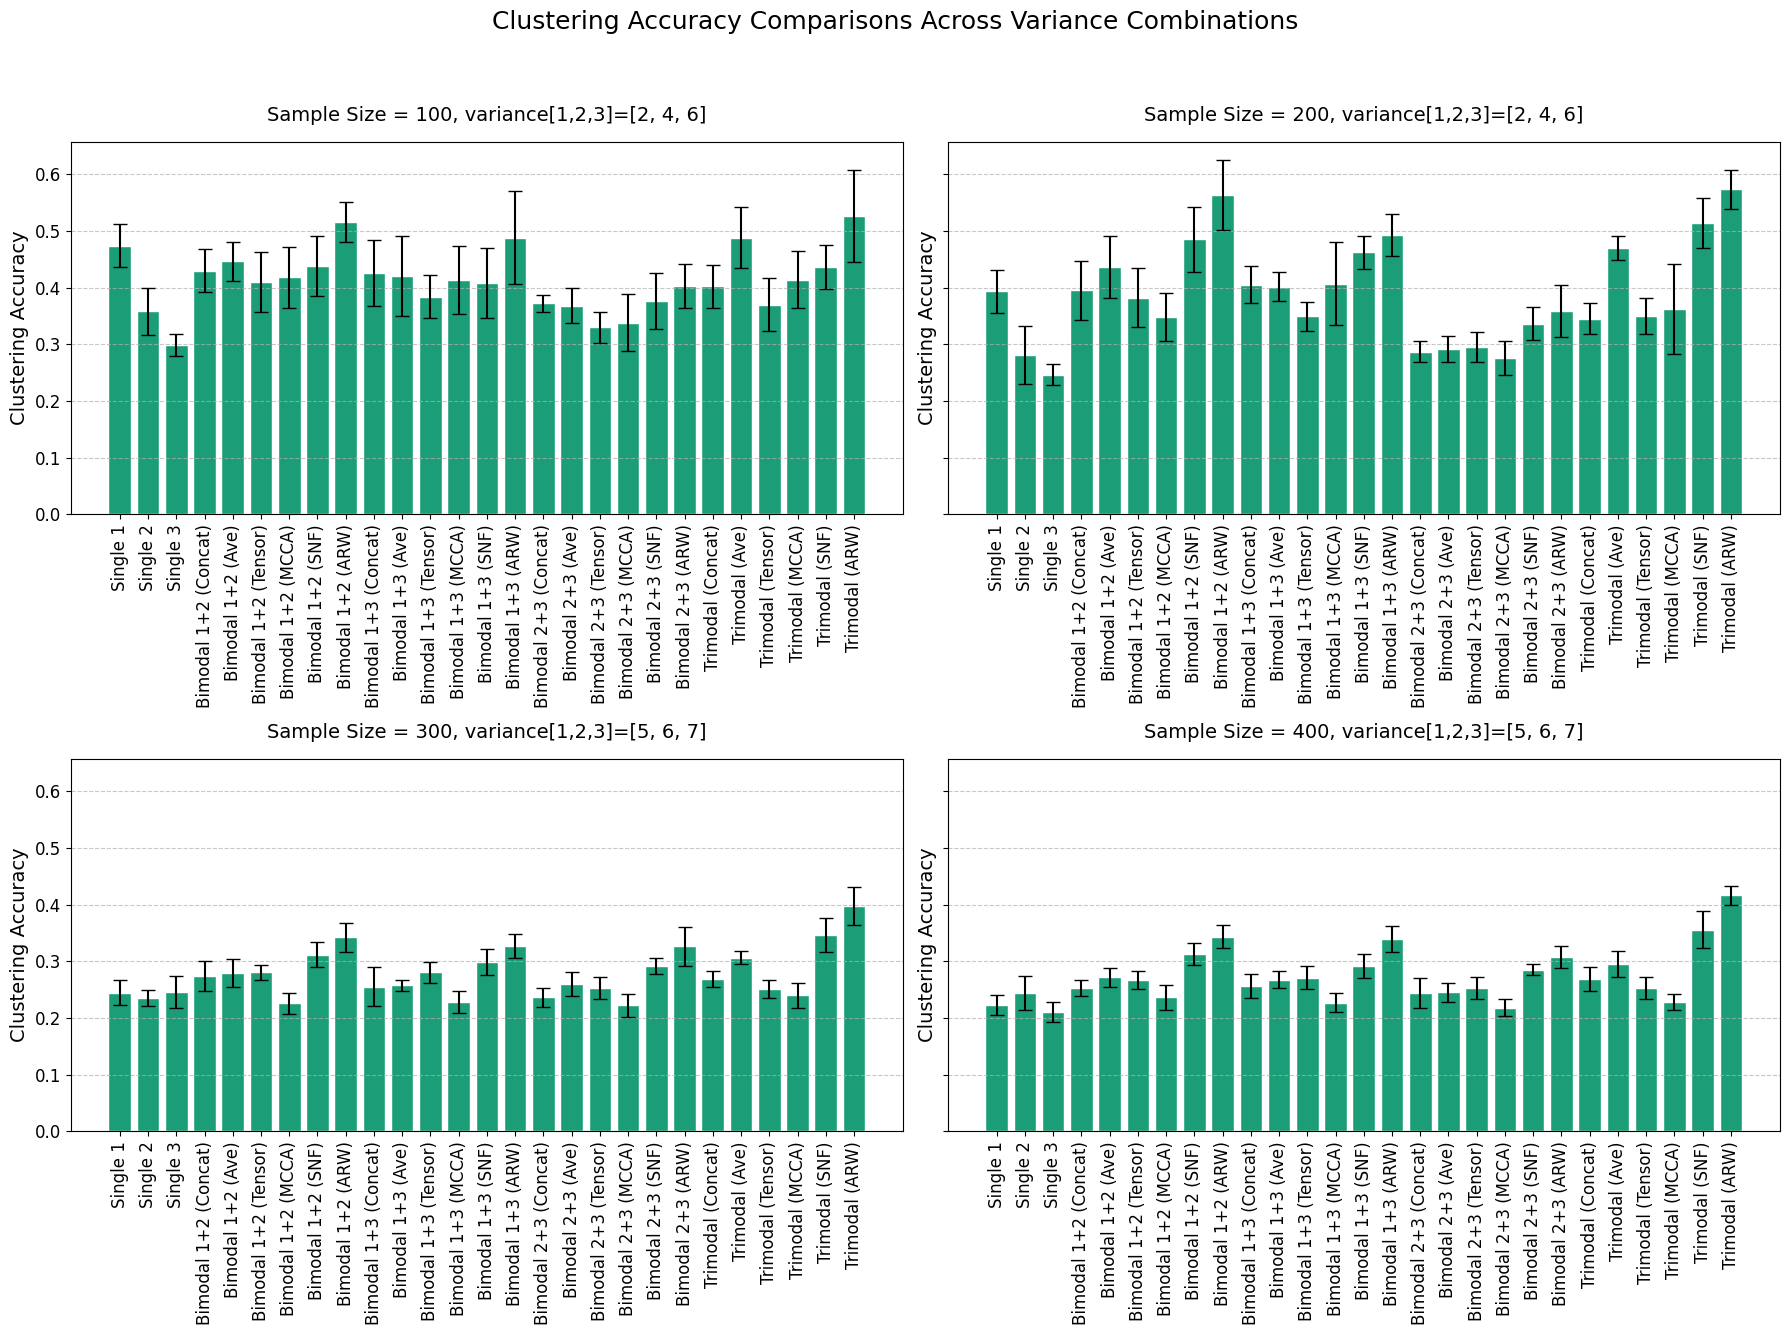

In [27]:
run_GMM_variance_analysis_trimodal_fixed_mean(labels, 10, n_iterations=5)

### 2. Random mean test

In [6]:
def run_GMM_variance_analysis_trimodal(labels, GMM_dim, n_iterations=5):
    """
    Compare single-modal, bimodal, and trimodal clustering accuracy using various fusion methods,
    across different combinations of variances.

    Args:
        labels: True cluster labels for the data.
        sample_size: Number of samples to use for clustering.
        n_iterations: Number of runs to compute average accuracy.

    Returns:
        A single plot containing multiple subplots for all variance combinations.
    """
    # Variance combinations for x, y, z in {2.5, 4.0}
    combinations = [[200,2,4,6],[1000,2,4,6],[200,5,6,7],[1000,5,6,7]]

    # Initialize storage for results
    methods = [
        'single_1', 'single_2', 'single_3',
        'bimodal_12_concat', 'bimodal_12_Ave', 'bimodal_12_Tensor', 'bimodal_12_MCCA', 'bimodal_12_SNF', 'bimodal_12_ARW',
        'bimodal_13_concat', 'bimodal_13_Ave', 'bimodal_13_Tensor', 'bimodal_13_MCCA', 'bimodal_13_SNF', 'bimodal_13_ARW',
        'bimodal_23_concat', 'bimodal_23_Ave', 'bimodal_23_Tensor', 'bimodal_23_MCCA', 'bimodal_23_SNF', 'bimodal_23_ARW',
        'trimodal_concat', 'trimodal_Ave', 'trimodal_Tensor', 'trimodal_MCCA', 'trimodal_SNF', 'trimodal_ARW'
    ]
    results = {method: {'means': [], 'stds': []} for method in methods}

    for sample_size, variance1, variance2, variance3 in combinations:
        print(f"Running: sample_size={sample_size}, variance1={variance1}, variance2={variance2}, variance3={variance3}")

        # Temporary accuracy storage for this variance combination
        accuracies = {method: [] for method in methods}

        for _ in range(n_iterations):  # Repeat experiment
            # Generate samples with specified variances
            y = labels[:sample_size]
            X = data_normalized[:sample_size]
            X1_sample = GMM_sampler(X, y, GMM_dim, var_scale=variance1)
            X2_sample = GMM_sampler(X, y, GMM_dim, var_scale=variance2)
            X3_sample = GMM_sampler(X, y, GMM_dim, var_scale=variance3)

            # Single-modal clustering
            accuracies['single_1'].append(cluster_accuracy(y, SpectralClustering_Single(X1_sample, n_clusters=10, Use_PCA=False)))
            accuracies['single_2'].append(cluster_accuracy(y, SpectralClustering_Single(X2_sample, n_clusters=10, Use_PCA=False)))
            accuracies['single_3'].append(cluster_accuracy(y, SpectralClustering_Single(X3_sample, n_clusters=10, Use_PCA=False)))

            # Bimodal methods
            for pair, prefix in zip([(X1_sample, X2_sample), (X1_sample, X3_sample), (X2_sample, X3_sample)],
                                    ['bimodal_12', 'bimodal_13', 'bimodal_23']):
                accuracies[f'{prefix}_concat'].append(cluster_accuracy(y, MultiModal_SpectralClustering_Concat(list(pair), n_clusters=10)))
                accuracies[f'{prefix}_Ave'].append(cluster_accuracy(y, MultiModal_SpectralClustering_Ave(list(pair), n_clusters=10)))
                accuracies[f'{prefix}_Tensor'].append(cluster_accuracy(y, MultiModal_SpectralClustering_Tensor(list(pair), n_clusters=10)))
                accuracies[f'{prefix}_MCCA'].append(cluster_accuracy(y, run_mcca_fixed_clusters_simple(list(pair), n_clusters=10)))
                accuracies[f'{prefix}_SNF'].append(cluster_accuracy(y, MultiModal_SNF(list(pair), n_clusters=10)))
                accuracies[f'{prefix}_ARW'].append(cluster_accuracy(y, MultiModal_SpectralClustering_ARW(list(pair), n_clusters=10)))

            # Trimodal methods
            trimodal_data = [X1_sample, X2_sample, X3_sample]
            accuracies['trimodal_concat'].append(cluster_accuracy(y, MultiModal_SpectralClustering_Concat(trimodal_data, n_clusters=10)))
            accuracies['trimodal_Ave'].append(cluster_accuracy(y, MultiModal_SpectralClustering_Ave(trimodal_data, n_clusters=10)))
            accuracies['trimodal_Tensor'].append(cluster_accuracy(y, MultiModal_SpectralClustering_Tensor(trimodal_data, n_clusters=10)))
            accuracies['trimodal_MCCA'].append(cluster_accuracy(y, run_mcca_fixed_clusters_simple(trimodal_data, n_clusters=10)))
            accuracies['trimodal_SNF'].append(cluster_accuracy(y, MultiModal_SNF(trimodal_data, n_clusters=10)))
            accuracies['trimodal_ARW'].append(cluster_accuracy(y, MultiModal_SpectralClustering_ARW(trimodal_data, n_clusters=10)))

        # Store results
        for method in methods:
            results[method]['means'].append(np.mean(accuracies[method]))
            results[method]['stds'].append(np.std(accuracies[method]))

    # Generate a single plot with subplots for all variance combinations
    n_rows, n_cols = 2, 2  # Define 2x2 grid for 4 plots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 14), sharey=True)  # Adjust figure size for academic papers
    axes = axes.flatten()

    for idx, (sample_size,variance1,variance2,variance3) in enumerate(combinations):
        # Extract mean and std for this variance combination
        means = [results[method]['means'][idx] for method in methods]
        stds = [results[method]['stds'][idx] for method in methods]

        # Create bar chart
        x_labels = [
            "Single 1", "Single 2", "Single 3",
            "Bimodal 1+2 (Concat)", "Bimodal 1+2 (Ave)", "Bimodal 1+2 (Tensor)", "Bimodal 1+2 (MCCA)", "Bimodal 1+2 (SNF)", "Bimodal 1+2 (ARW)",
            "Bimodal 1+3 (Concat)", "Bimodal 1+3 (Ave)", "Bimodal 1+3 (Tensor)", "Bimodal 1+3 (MCCA)", "Bimodal 1+3 (SNF)", "Bimodal 1+3 (ARW)",
            "Bimodal 2+3 (Concat)", "Bimodal 2+3 (Ave)", "Bimodal 2+3 (Tensor)", "Bimodal 2+3 (MCCA)", "Bimodal 2+3 (SNF)", "Bimodal 2+3 (ARW)",
            "Trimodal (Concat)", "Trimodal (Ave)", "Trimodal (Tensor)", "Trimodal (MCCA)", "Trimodal (SNF)", "Trimodal (ARW)"
        ]
        x = np.arange(len(methods))

        ax = axes[idx]
        ax.bar(x, means, yerr=stds, capsize=5, color='#1b9e77', edgecolor='white')
        ax.set_xticks(x)
        ax.set_xticklabels(x_labels, rotation=90, ha="center", fontsize=12)  # Increased font size for x-axis labels
        ax.set_title(f"Sample Size = {sample_size}, variance[1,2,3]={[variance1,variance2,variance3]}", fontsize=14, pad=15)  # Larger subplot titles
        ax.set_ylabel("Clustering Accuracy", fontsize=14)  # Larger y-axis label
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.grid(True, axis='y', linestyle='--', alpha=0.7)

    # Turn off unused subplots if there are fewer combinations than subplots
    for ax in axes[len(combinations):]:
        ax.axis('off')

    # Customize layout and overall title
    fig.suptitle("Clustering Accuracy Comparisons Across Variance Combinations", fontsize=18, y=0.95)  # Larger overall title
    fig.tight_layout(rect=[0, 0, 1, 0.92])  # Adjust layout to avoid overlap and fit everything well

    plt.show()

Running: sample_size=200, variance1=2, variance2=4, variance3=6
Running: sample_size=1000, variance1=2, variance2=4, variance3=6
Running: sample_size=200, variance1=5, variance2=6, variance3=7
Running: sample_size=1000, variance1=5, variance2=6, variance3=7


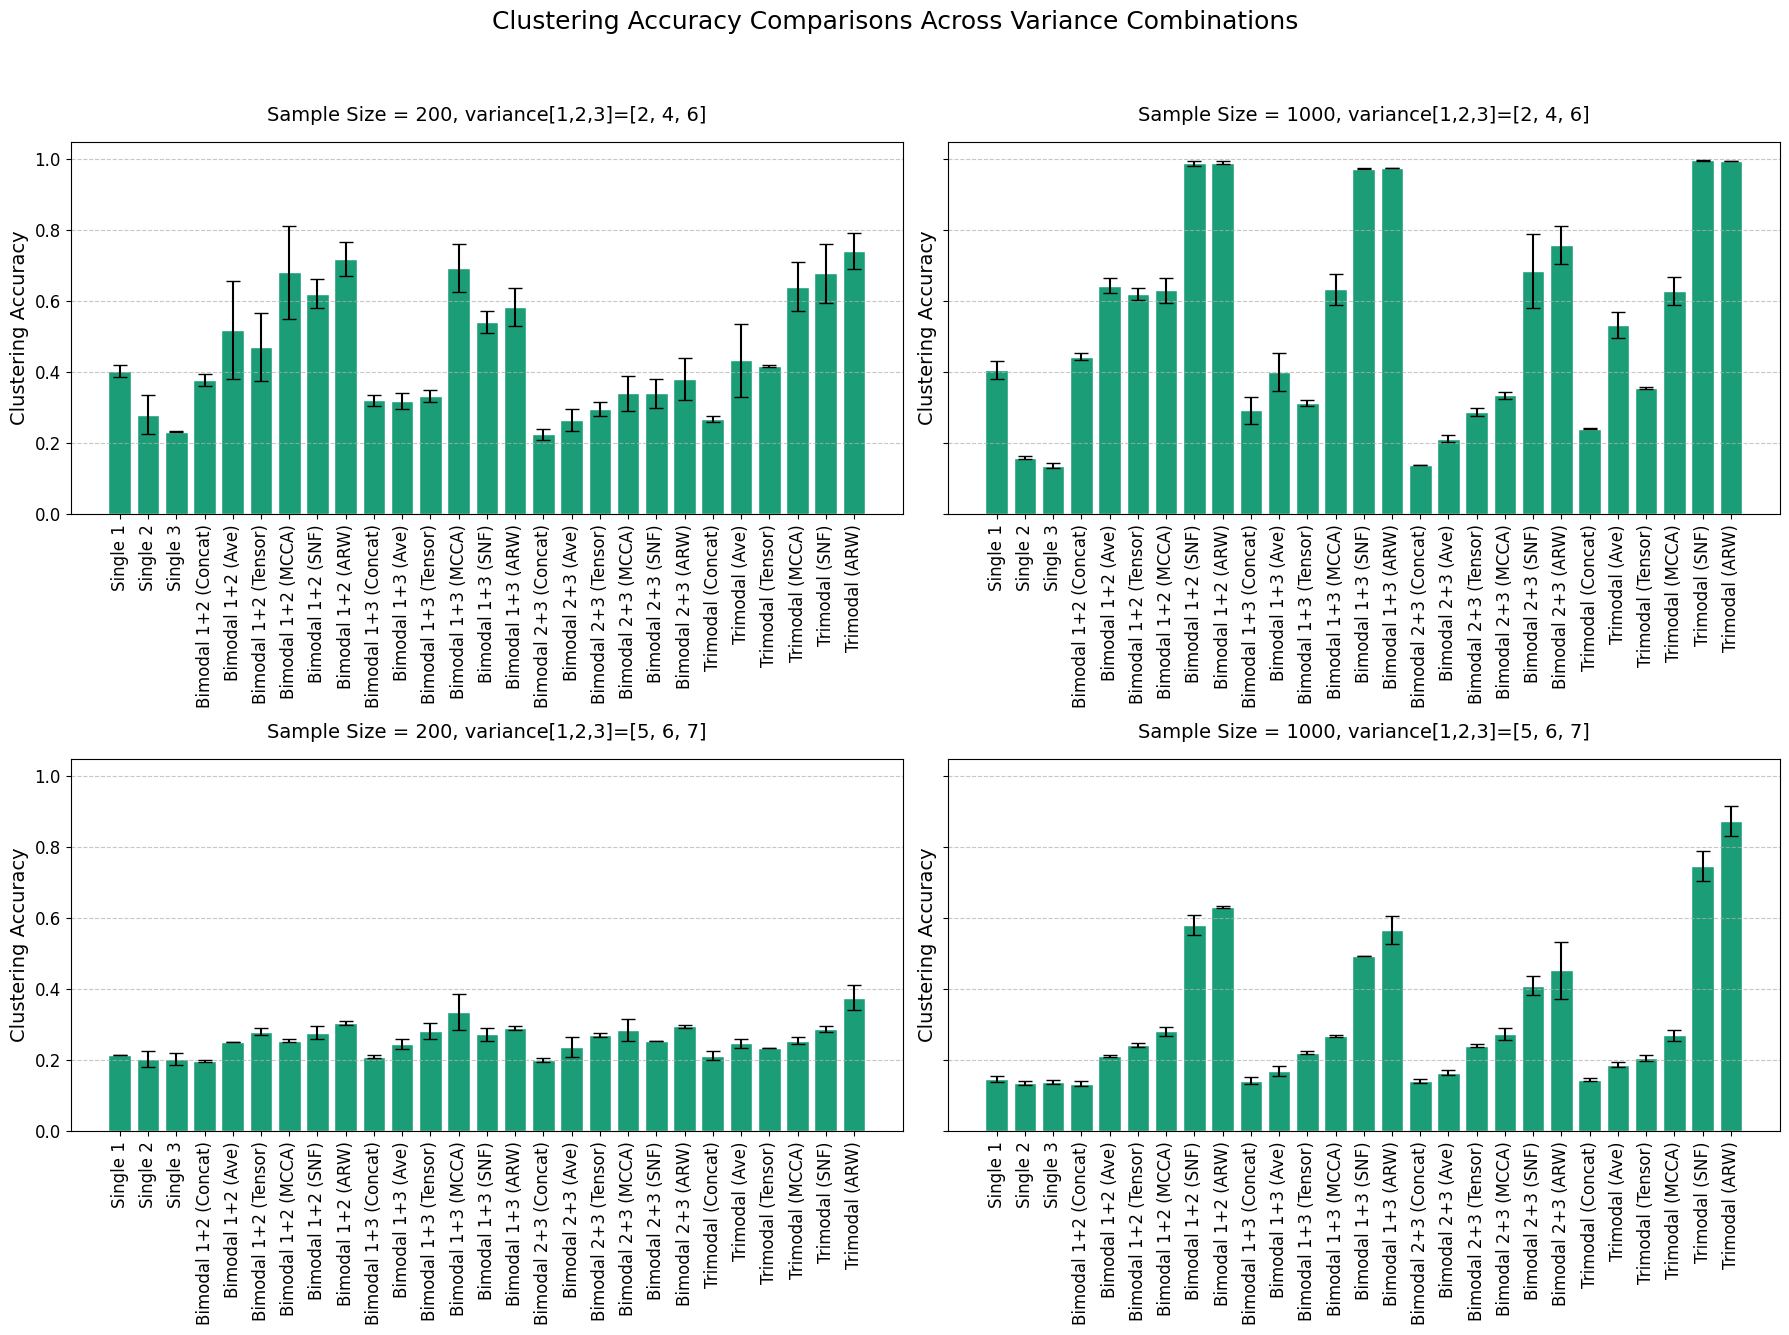

In [43]:
run_GMM_variance_analysis_trimodal(labels, 10, n_iterations=2)

## ARW on MNIST

In [11]:
def run_GMM_variance_analysis_trimodal_MNIST(labels, GMM_dim, n_iterations=5):
    """
    Compare single-modal, bimodal, and trimodal clustering accuracy using various fusion methods,
    across specific variance combinations, with an academic paper-style plot.

    Args:
        labels: True cluster labels for the data.
        sample_size: Number of samples to use for clustering.
        n_iterations: Number of runs to compute average accuracy.

    Returns:
        A single plot containing 2x2 subplots for variance combinations.
    """
    # Variance combinations for x, y, z
    combinations = [[200,2,4],[1000,2,4],[200,4,6],[1000,4,6]]

    # Initialize storage for results
    methods = [
        'single_1', 'single_2', 'single_3 = MNIST',
        'bimodal_12_concat', 'bimodal_12_Ave', 'bimodal_12_Tensor', 'bimodal_12_MCCA', 'bimodal_12_SNF', 'bimodal_12_ARW',
        'bimodal_13_concat', 'bimodal_13_Ave', 'bimodal_13_Tensor', 'bimodal_13_MCCA', 'bimodal_13_SNF', 'bimodal_13_ARW',
        'bimodal_23_concat', 'bimodal_23_Ave', 'bimodal_23_Tensor', 'bimodal_23_MCCA', 'bimodal_23_SNF', 'bimodal_23_ARW',
        'trimodal_concat', 'trimodal_Ave', 'trimodal_Tensor', 'trimodal_MCCA', 'trimodal_SNF', 'trimodal_ARW'
    ]
    results = {method: {'means': [], 'stds': []} for method in methods}

    for sample_size, variance1, variance2 in combinations:
        print(f"Running: sample_size={sample_size}, variance1={variance1}, variance2={variance2}")

        # Temporary accuracy storage for this variance combination
        accuracies = {method: [] for method in methods}

        for _ in range(n_iterations):  # Repeat experiment
            # Generate samples with specified variances
            y = labels[:sample_size]
            X = data_reduced[:sample_size]
            X1_sample = GMM_sampler(X, y, 20, var_scale=variance1)
            X2_sample = GMM_sampler(X, y, 20, var_scale=variance2)

            # Single-modal clustering
            accuracies['single_1'].append(cluster_accuracy(y, SpectralClustering_Single(X1_sample, n_clusters=10, Use_PCA=False)))
            accuracies['single_2'].append(cluster_accuracy(y, SpectralClustering_Single(X2_sample, n_clusters=10, Use_PCA=False)))
            accuracies['single_3 = MNIST'].append(cluster_accuracy(y, SpectralClustering_Single(X, n_clusters=10, Use_PCA=False)))

            # Bimodal and Trimodal methods (loop similar to your implementation)
            for pair, prefix in zip([(X1_sample, X2_sample), (X1_sample, X), (X2_sample, X)], ['bimodal_12', 'bimodal_13', 'bimodal_23']):
                accuracies[f'{prefix}_concat'].append(cluster_accuracy(y, MultiModal_SpectralClustering_Concat(pair, n_clusters=10)))
                accuracies[f'{prefix}_Ave'].append(cluster_accuracy(y, MultiModal_SpectralClustering_Ave(pair, n_clusters=10)))
                accuracies[f'{prefix}_Tensor'].append(cluster_accuracy(y, MultiModal_SpectralClustering_Tensor(pair, n_clusters=10)))
                accuracies[f'{prefix}_MCCA'].append(cluster_accuracy(y, run_mcca_fixed_clusters_simple(pair, n_clusters=10)))
                accuracies[f'{prefix}_SNF'].append(cluster_accuracy(y, MultiModal_SNF(pair, n_clusters=10)))
                accuracies[f'{prefix}_ARW'].append(cluster_accuracy(y, MultiModal_SpectralClustering_ARW(pair, n_clusters=10)))

            # Trimodal methods
            trimodal_data = [X1_sample, X2_sample, X]
            accuracies['trimodal_concat'].append(cluster_accuracy(y, MultiModal_SpectralClustering_Concat(trimodal_data, n_clusters=10)))
            accuracies['trimodal_Ave'].append(cluster_accuracy(y, MultiModal_SpectralClustering_Ave(trimodal_data, n_clusters=10)))
            accuracies['trimodal_Tensor'].append(cluster_accuracy(y, MultiModal_SpectralClustering_Tensor(trimodal_data, n_clusters=10)))
            accuracies['trimodal_MCCA'].append(cluster_accuracy(y, run_mcca_fixed_clusters_simple(trimodal_data, n_clusters=10)))
            accuracies['trimodal_SNF'].append(cluster_accuracy(y, MultiModal_SNF(trimodal_data, n_clusters=10)))
            accuracies['trimodal_ARW'].append(cluster_accuracy(y, MultiModal_SpectralClustering_ARW(trimodal_data, n_clusters=10)))

        # Store results
        for method in methods:
            results[method]['means'].append(np.mean(accuracies[method]))
            results[method]['stds'].append(np.std(accuracies[method]))

    # Generate a single plot with subplots for all variance combinations
    n_rows, n_cols = 2, 2  # Define 2x2 grid for 4 plots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 14), sharey=True)  # Adjust figure size for academic papers
    axes = axes.flatten()

    for idx, (sample_size,variance1,variance2) in enumerate(combinations):
        # Extract mean and std for this variance combination
        means = [results[method]['means'][idx] for method in methods]
        stds = [results[method]['stds'][idx] for method in methods]

        # Create bar chart
        x_labels = [
            "Single 1", "Single 2", "Single 3 = MNIST",
            "Bimodal 1+2 (Concat)", "Bimodal 1+2 (Ave)", "Bimodal 1+2 (Tensor)", "Bimodal 1+2 (MCCA)", "Bimodal 1+2 (SNF)", "Bimodal 1+2 (ARW)",
            "Bimodal 1+3 (Concat)", "Bimodal 1+3 (Ave)", "Bimodal 1+3 (Tensor)", "Bimodal 1+3 (MCCA)", "Bimodal 1+3 (SNF)", "Bimodal 1+3 (ARW)",
            "Bimodal 2+3 (Concat)", "Bimodal 2+3 (Ave)", "Bimodal 2+3 (Tensor)", "Bimodal 2+3 (MCCA)", "Bimodal 2+3 (SNF)", "Bimodal 2+3 (ARW)",
            "Trimodal (Concat)", "Trimodal (Ave)", "Trimodal (Tensor)", "Trimodal (MCCA)", "Trimodal (SNF)", "Trimodal (ARW)"
        ]
        x = np.arange(len(methods))

        ax = axes[idx]
        ax.bar(x, means, yerr=stds, capsize=5, color='#1b9e77', edgecolor='white')
        ax.set_xticks(x)
        ax.set_xticklabels(x_labels, rotation=90, ha="center", fontsize=12)  # Increased font size for x-axis labels
        ax.set_title(f"Sample Size = {sample_size}, variance[1,2]={[variance1,variance2]}", fontsize=14, pad=15)  # Larger subplot titles
        ax.set_ylabel("Clustering Accuracy", fontsize=14)  # Larger y-axis label
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.grid(True, axis='y', linestyle='--', alpha=0.7)

    # Turn off unused subplots if there are fewer combinations than subplots
    for ax in axes[len(combinations):]:
        ax.axis('off')

    # Customize layout and overall title
    fig.suptitle("Clustering Accuracy Comparisons Across Variance Combinations", fontsize=18, y=0.95)  # Larger overall title
    fig.tight_layout(rect=[0, 0, 1, 0.92])  # Adjust layout to avoid overlap and fit everything well

    plt.show()

Running: sample_size=200, variance1=2, variance2=4
Running: sample_size=1000, variance1=2, variance2=4
Running: sample_size=200, variance1=4, variance2=6
Running: sample_size=1000, variance1=4, variance2=6


/Users/shizhouxu/Desktop/SX_Workspace/WHOMP_venv/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


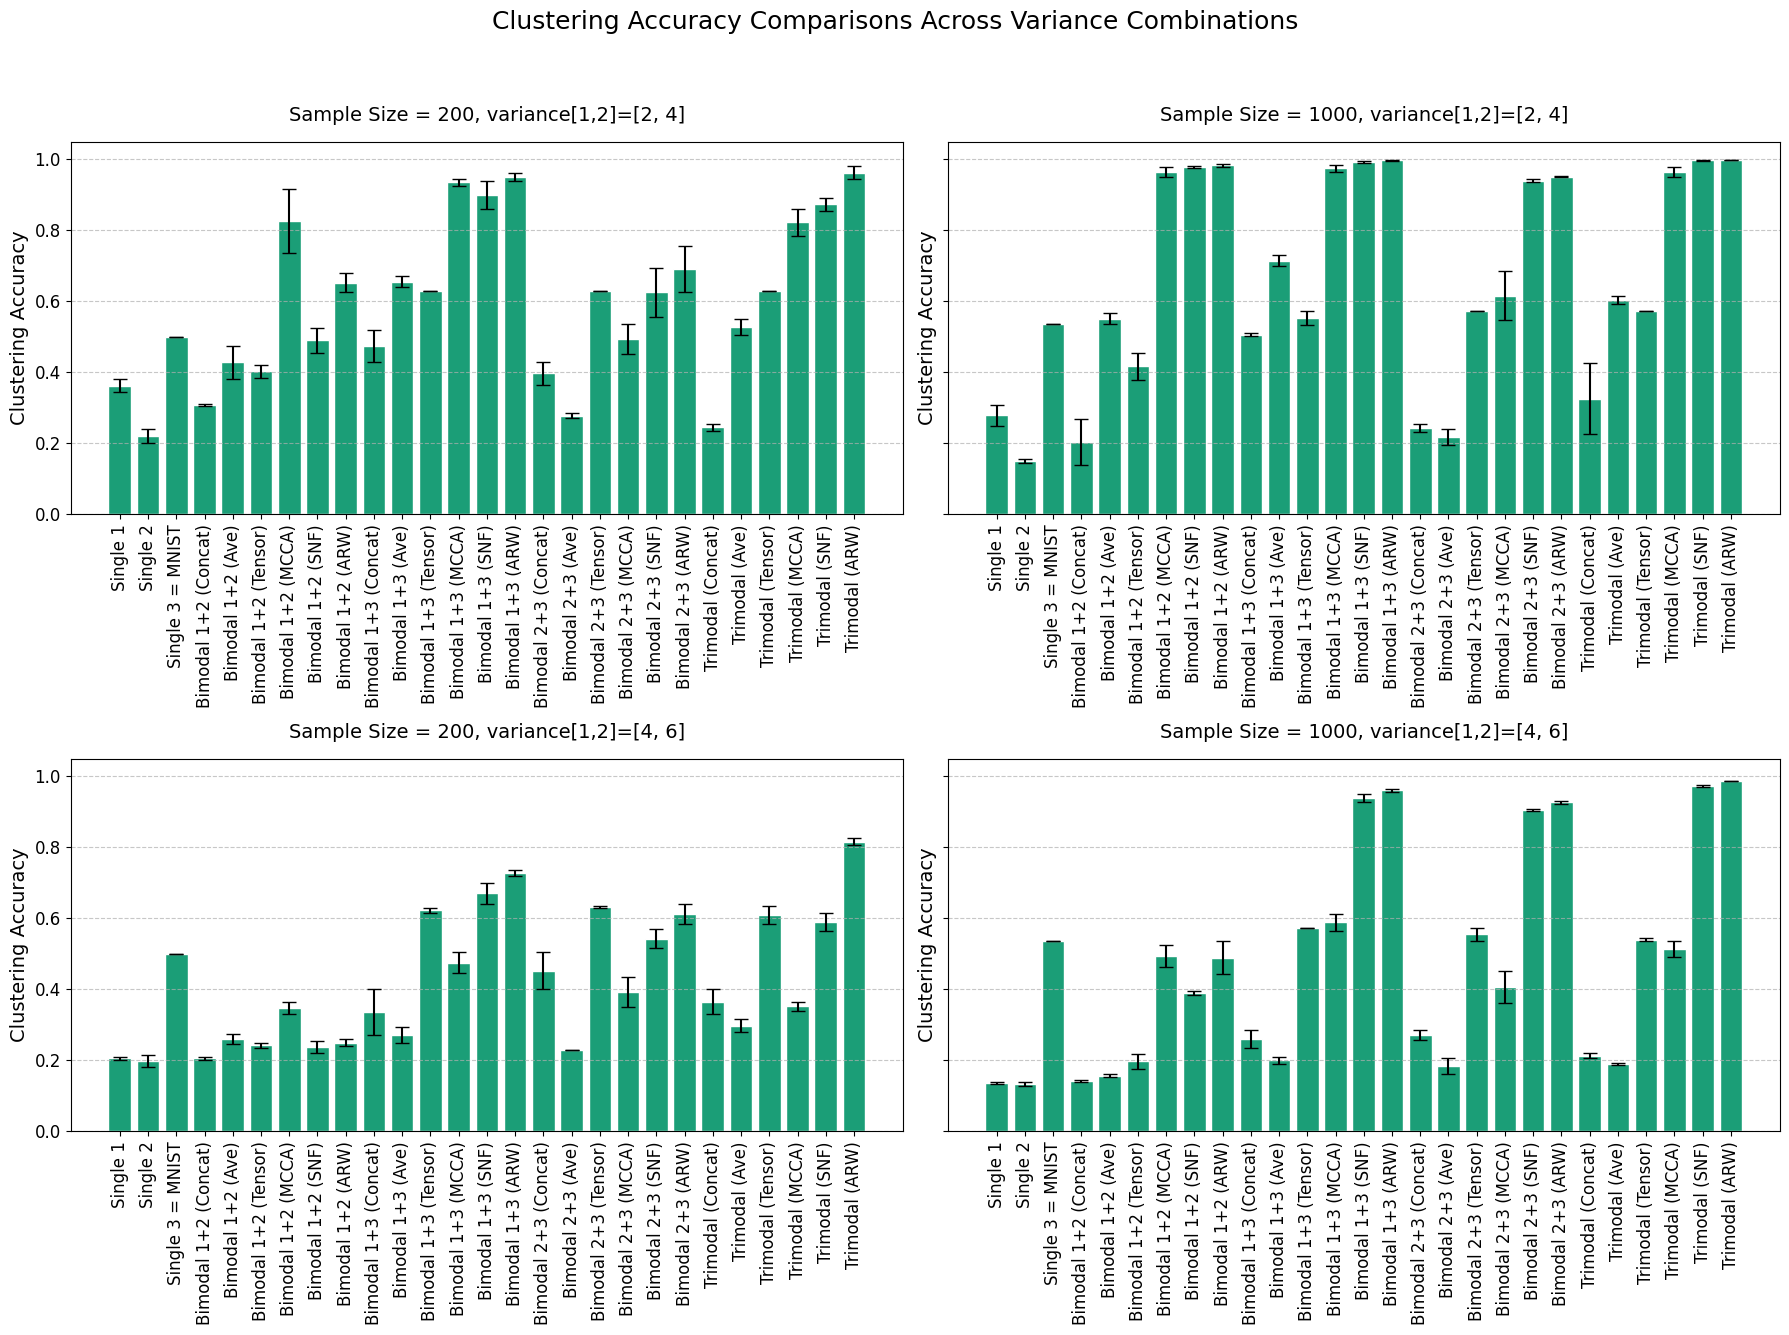

In [44]:
run_GMM_variance_analysis_trimodal_MNIST(labels, 20, n_iterations=2)